<a href="https://colab.research.google.com/github/Seba485/Deep-Learning-project/blob/DEV_Hyun/alzheimer_mri_model_tensorflow_2_3_data_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction + Set-up

Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image. This model achieves an a high ROC AUC score.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.

We'll be using a GPU accelerator for this NB.

In [1]:
##### import packages #####
import os
from PIL import Image
from glob import glob
import shutil
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
# import kaggledatasets
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
try:
  from scikeras.wrappers import KerasClassifier
except:
  !pip install scikeras -q
  from scikeras.wrappers import KerasClassifier

##### set-up gpu/tpu #####
# check & mount in case of using colab
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    print('running the notebook in colab')
except:
    pass

# check if tpu is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    print('No TPU found')
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

# check if gpu is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Found {len(gpus)} GPU")
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2.14.0
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
running the notebook in colab
No TPU found
Number of replicas: 1
Found 1 GPU


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [128, 128]
# EPOCHS = 15

# Data Loading

We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images) for our tutorial. `tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format.

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!
In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. To learn more about the importance of having a validation split, check out this [lesson](https://developers.google.com/machine-learning/crash-course/validation/another-partition) from Google's Machine Learning Crash Course.

In [3]:
##### split and save dataset into train/val and test data #####

# specify local dataset path
# dataset_path = 'Dataset' # Sebastiano
dataset_path = '/content/drive/MyDrive/UNIPD-DLNR/Dataset' # Hyunjung

train_path = dataset_path+'/train' #folder doesn’t exist yet
test_path= dataset_path+'/test'
test_size = 0.2
val_size = 0.2
classes = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
print(classes)

if os.path.isdir(train_path):
    print('Dataset has already been splited and saved into train/val and test data.')
else:
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    print(classes)

    for class_name in classes:
        print(class_name)
        class_path = os.path.join(dataset_path, class_name)
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)

        # Get the list of files in the class
        files = os.listdir(class_path)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Divide the class dataset into training and test sets
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

        # Save the training files to the training folder
        for file in train_files:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(train_path, class_name, file)
            shutil.copy(src_path, dst_path)

        # Save the test files to the test folder
        for file in test_files:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(test_path, class_name, file)
            shutil.copy(src_path, dst_path)

##### split train/val into train and val data #####
# set batch size: 1) batch_size=40, 2) take 10% of the train+val set as the batch size
customized_batchsize = True # True if we want customized batch size over the dataset size
if customized_batchsize:
    trainval_cnt = sum([len(files) for _, _, files in os.walk(train_path)])
    test_cnt = sum([len(files) for _, _, files in os.walk(test_path)]) # might use this in case of using different batch size for test set
    BATCH_SIZE = round(trainval_cnt * val_size * 0.1)
else:

    BATCH_SIZE = 40
print("Batch Size for train set and val set:", BATCH_SIZE)

# split dataset and save into tf Dataset object
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=val_size,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=val_size,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
Dataset has already been splited and saved into train/val and test data.
Batch Size for train set and val set: 102
Found 5119 files belonging to 4 classes.
Using 4096 files for training.
Found 5119 files belonging to 4 classes.
Using 1023 files for validation.


We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [4]:
train_ds.class_names = classes
val_ds.class_name = classes
NUM_CLASSES = len(classes)

# Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

Mild_Demented class has 716 samples in train set.
Moderate_Demented class has 51 samples in train set.
Non_Demented class has 2560 samples in train set.
Very_Mild_Demented class has 1792 samples in train set.


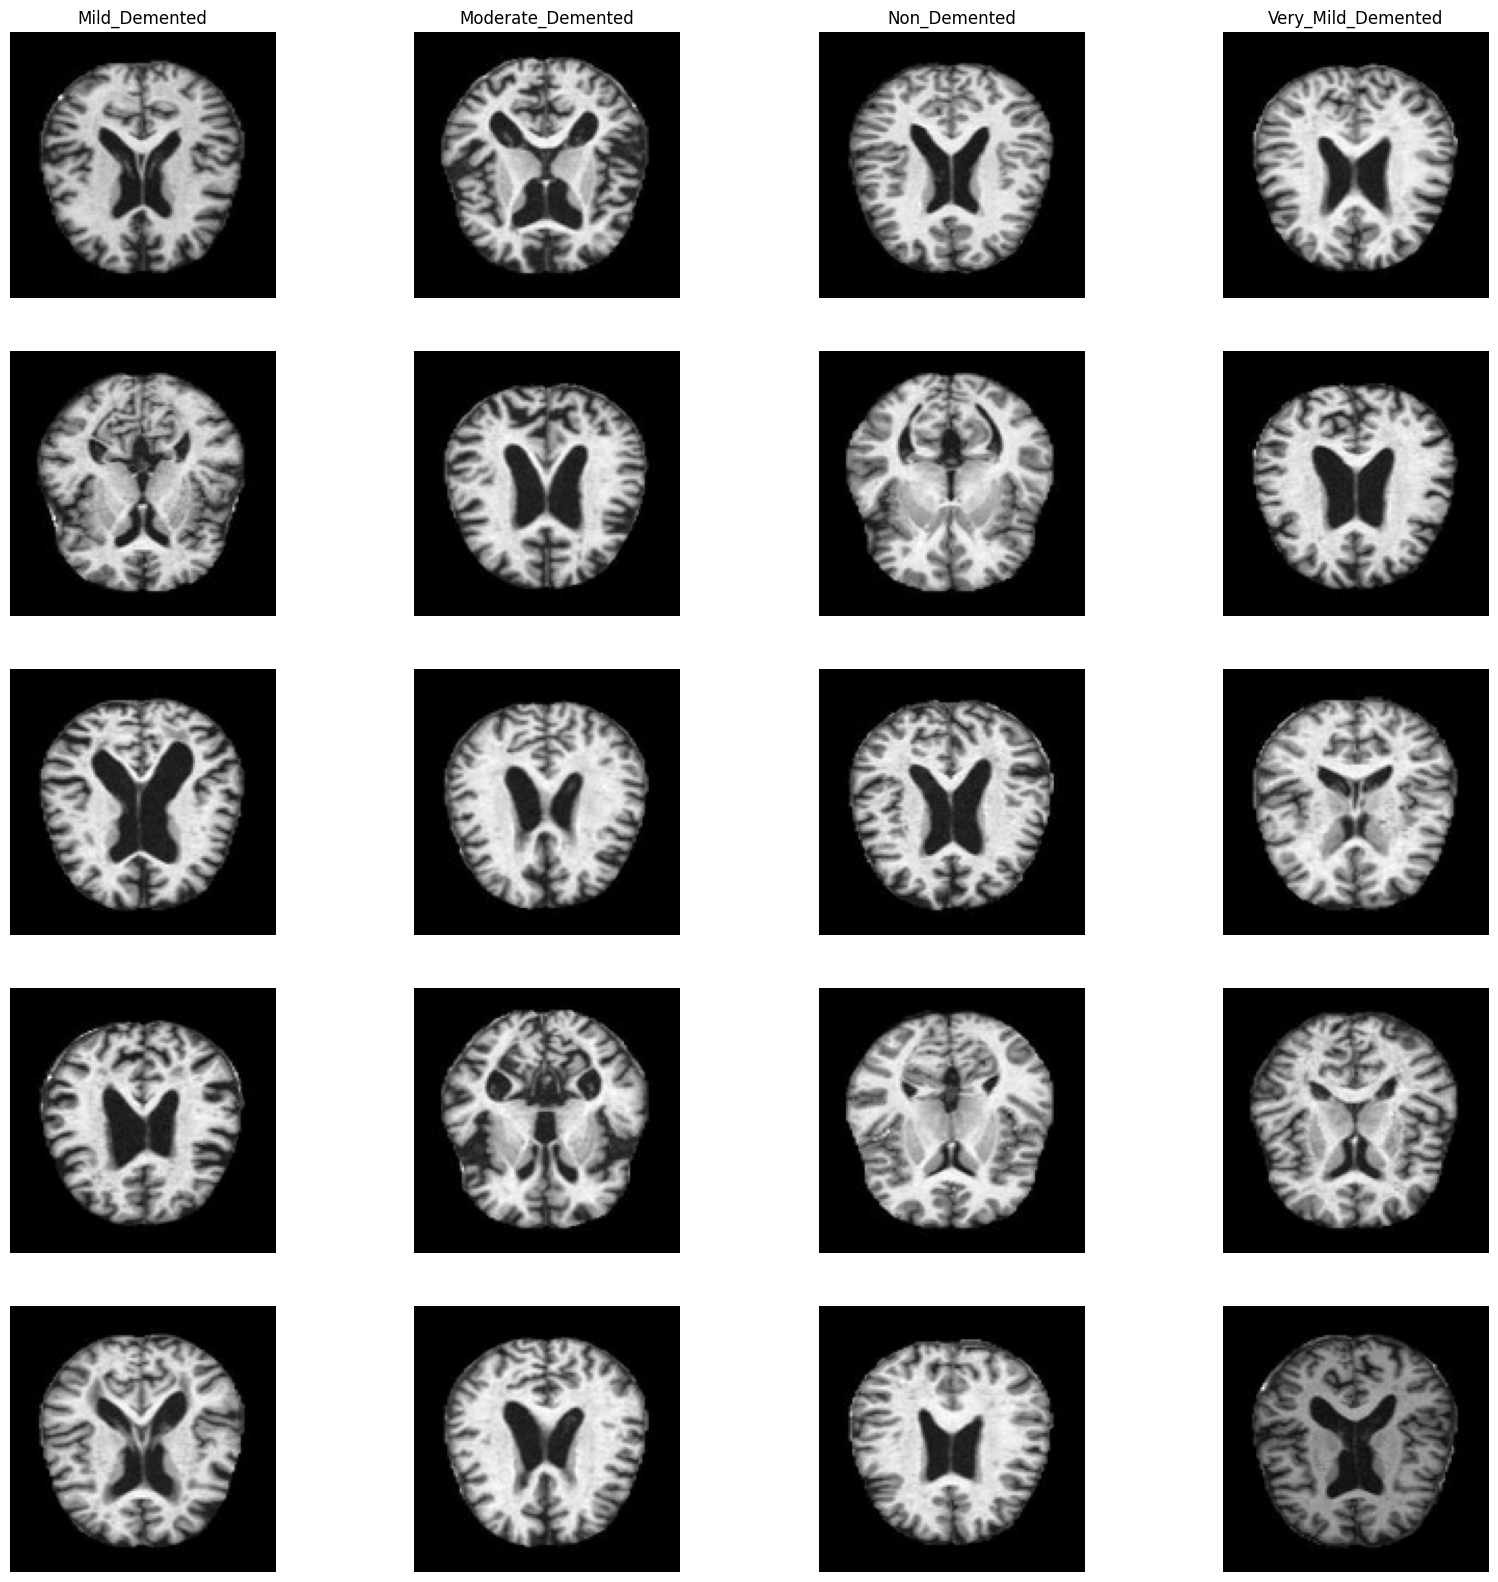

In [5]:
##### check the number of samples within each class in train set #####
# create a dictionary where:
# - keys are folder names (-> the 8 classes)
# - values are the filenames for the files in each folder
imgs = {c: glob(os.path.join(train_path, c, "*")) for c in classes}
for key in imgs.keys():
   print("{} class has {} samples in train set.".format(key,len(imgs[key])))

##### plot 5 samples per class #####
# CHANGE--> PLOT SOME (5) IMAGES PER CLASS ! TO SEE BETTER DIFFERENCES
nrows = 5
fig, axs = plt.subplots(nrows=nrows, ncols=len(classes), figsize=(20, 20))

for i, (c, fnames) in enumerate(imgs.items()): # i is the count, (images,labels) key and value
    axs[0,i].set_title(c)
    for n in range(nrows):
        fname = (fnames[n]).replace('\\','/')
        im = Image.open(fname)
        # print(im.mode)
        # im = im.convert('L') # image is already saved in 'L' mode
        axs[n,i].imshow(im, cmap='gray')
for ax in axs.flatten():
    ax.axis("off")

In [7]:
##### extract numpy arrays of images and labels from tensorflow Dataset Object #####
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def images_labels_fromPrefetch(dataset):
    dataset_it = dataset.as_numpy_iterator() # Numpy iterator
    all_labels=[]; all_images=[]
    for batch_images, batch_labels in dataset_it:
        all_labels.extend(batch_labels)
        all_images.append(batch_images)
    return all_images, all_labels

tensors_train, labels_train = images_labels_fromPrefetch(train_ds)
_, labels_val = images_labels_fromPrefetch(val_ds)

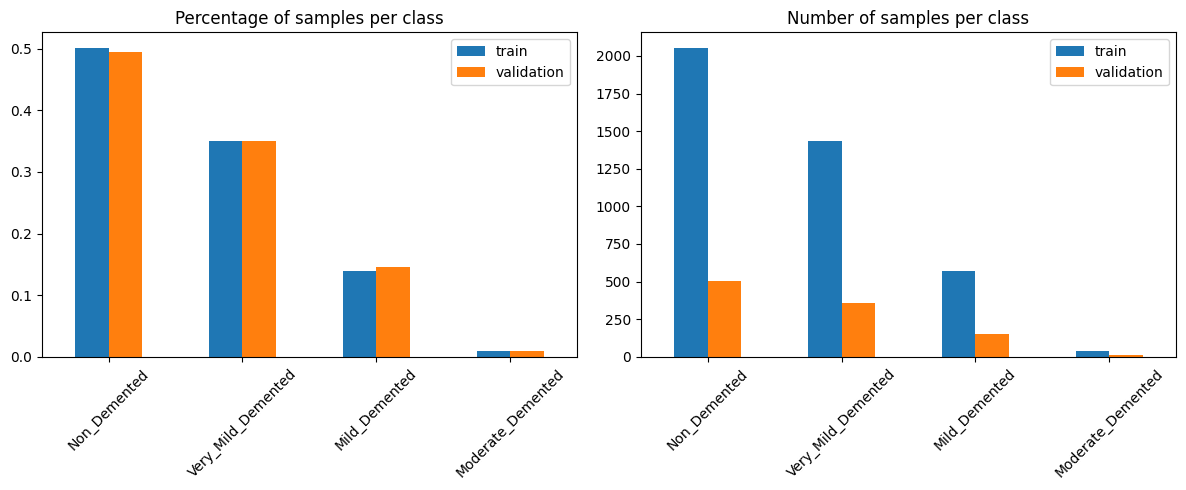

<Figure size 640x480 with 0 Axes>

In [8]:
##### check class ditribution of dataset #####
train_labels = [classes[idx] for idx in labels_train]
val_labels = [classes[idx] for idx in labels_val]

fig,axs = plt.subplots(1,2,figsize=(12,5))

vis_ratio = True # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[0], title=vis_title, rot=45)
axs[0].legend(['train', 'validation'])

plt.subplot(1,2,2)
vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[1], title=vis_title, rot=45)
axs[1].legend(['train', 'validation'])

plt.tight_layout()

# Show the plot
plt.show()
plt.savefig('Dataset distribution.png')

Is possible to see how the dataset is unbalanced, is usefull to apply data aumentation in a specific manner for each class in order to prevent understimation of the minority class.

# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering. Learn more about feature engineering [here](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering).

In [9]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [10]:
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
## Layers for data augmentation

RandomZoom_layer1=(tf.keras.layers.RandomZoom(
    height_factor=(0.1, 0.3),
    width_factor=(0.1, 0.3),
    fill_mode="constant",
    seed=2023
))

RandomWidth_layer1=tf.keras.layers.RandomWidth(
    (-0.2,0.2), interpolation='bilinear', seed=2023)

RandomHeight_layer1=tf.keras.layers.RandomHeight(
    (-0.2,0.2), interpolation='bilinear', seed=2023)

RandomRotation_layer1=tf.keras.layers.RandomRotation(
    (-0.2,0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=2023)

RandomRotation_layer2=tf.keras.layers.RandomRotation(
    (-0.2,0.2),
    fill_mode='constant',
    interpolation='bilinear', fill_value=0.0,
    seed=2023)

RandomFlip_layer1=tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=2023)

RandomTranslation_layer1=tf.keras.layers.RandomTranslation(
    (-0.2,0.2),
     (-0.2,0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=2023)

RandomTranslation_layer2=tf.keras.layers.RandomTranslation(
    (-0.2,0.2),
     (-0.2,0.2),
    fill_mode='constant',
    interpolation='bilinear',
    seed=2023,fill_value=0.0)

RandomCrop_layer1=tf.keras.layers.RandomCrop(
    120,120, seed=2023)

RandomBrightness_layer1=tf.keras.layers.RandomBrightness(
    0.2, seed=2023)

RandomContrast_layer1=tf.keras.layers.RandomContrast(
    0.2 , seed=2023)
input_layer= tf.keras.Input(shape=(*IMAGE_SIZE, 3))

In [15]:
# DATA AUGMENTATION FOR BALANCING CLASSES

#Class - 1: Mild Demented (896 images)
#Class - 2: Moderate Demented (64 images)
#Class - 3: Non Demented (3200 images)
#Class - 4: Very Mild Demented (2240 images)


#EXTRACT LABELS
# labels_train: 1d array of dimension (4095)
number_of0=np.count_nonzero(labels_train==0)  #568= Class 1 : Mild Demented--> 3,6 (=4) data aug
number_of1=np.count_nonzero(labels_train==1)  #41= Class  2: Moderate Demented (64 images)--> 50 data aug
number_of2=np.count_nonzero(labels_train==2)  #2053= Class 3: Non Demented (3200 images)--> 0 data aug
number_of3=np.count_nonzero(labels_train==3)  #1433 Class= 4: Very Mild Demented (2240 images)--> 1,43 (=1) data aug

# EXTRACT OBSERVATIONS
# tensors_train: list of 103 4D tensorflows tensors (40,128,128,3):
# list_of_arrays = [tensor.numpy() for tensor in tensors_train]  #list of 103 4D arrays  (40,128,128,3)
list_of_arrays = tensors_train # already saved as numpy array
s = list_of_arrays[0].shape  # (40,128,128,3)
images_tot = [np.reshape((tensor), (-1, 128, 128, 3)) for tensor in list_of_arrays]  # 4D array (4095,128,128,3)
images_tot = list(np.concatenate(images_tot, axis=0))  # list of 4095 3d arrays
example=images_tot[0]   #3darray (128,128,3); all values in 3rd dimension are the same --> example[i,j,1]=example[i,j,2]=example[i,j,3]

augmented_images = []
augmented_labels = []
for i in range(len(images_tot)): #len is 4095, first dimensions
    image = images_tot[i]   #nd array (128,128,3)
    label = labels_train[i]

     # Apply data augmentation selectively based on the class label
    if label == 0: #568  Class 1 : Mild Demented--> 2053/568= 3,6 (=4) data aug
        augmented_image = RandomRotation_layer1(image)  #tensor
        augmented_image2= RandomTranslation_layer1(image)
        #augmented_image3=RandomZoom_layer1(image)
        augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image, augmented_image, augmented_image2])
    if label == 1: #41 Class  2: Moderate Demented --> 2053/41= 50 data aug
       augmented_image_list = [RandomRotation_layer1(image) for _ in range(10)]  #list of  50 tensors
       augmented_images_conc1= tf.concat([image] + augmented_image_list, axis=0)

       augmented_image2_list = [RandomTranslation_layer1(image) for _ in range(10)]
       augmented_images_conc2 = tf.concat([image] + augmented_image2_list, axis=0)
       augmented_images_conc2=augmented_images_conc2[128:]

       #for augmented_image in augmented_image2_list:

       augmented_image3_list = [RandomZoom_layer1(image)  for _ in range(10)]
       #for augmented_image in augmented_image3_list:
       augmented_images_conc3 = tf.concat([image] + augmented_image3_list, axis=0)
       augmented_images_conc3=augmented_images_conc3[128:]

       augmented_image4_list = [RandomFlip_layer1(image)  for _ in range(10)]
       #for augmented_image in augmented_image4_list:
       augmented_images_conc4 = tf.concat([image] + augmented_image4_list, axis=0)
       augmented_images_conc4=augmented_images_conc4[128:]

       augmented_image5_list = [RandomBrightness_layer1(image)  for _ in range(10)] ### I DON'T KNOW IF BRIGHTNESS WORKS!
       #for augmented_image in augmented_image5_list:
       #augmented_image_conc5 = tf.concat([image] + augmented_image5_list, axis=0)
       #augmented_images_conc5=augmented_image_conc5[128:]
       augmented_images_conc=tf.concat([augmented_images_conc1, augmented_images_conc2, augmented_images_conc3,augmented_images_conc4], axis=0)
       # ADD IMAGE!!
    if label == 2: #2053 Class 3: Non Demented --> 2053/2053=1 data aug
       augmented_image=image
       augmented_images_conc=augmented_image
        #augmented_images_conc =augmented_image
    if label == 3:
        if (random.random()<0.3) :  #1433 Class 4: Very Mild Demented --> 2053/1433 = 1,43 (=2) data aug
            augmented_image=RandomRotation_layer1(image)
            augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image,augmented_image])
        else:
            augmented_image=image
            augmented_images_conc=augmented_image

    #Target Shape of tensor
    target_shape = (128, 128, 3)

    # Calculate the number of tensors to be created
    num_tensors = augmented_images_conc.shape[0] // target_shape[0]

    # Reshape the tensor into multiple tensors of shape (128, 128, 3)
    augmented_images_resh = tf.split(augmented_images_conc, num_tensors, axis=0)

    for el in augmented_images_resh:
       augmented_images.append(el)
    for i in range(len(augmented_images_resh)):
       augmented_labels.append(label)


In [16]:
# function that let us to prefetch the augmented dataset
def Prefetch_fromLO(test_labels,test_observations,batch_size=BATCH_SIZE):
    test_labels_np = np.array(test_labels)
    test_observations_np = np.array(test_observations)

    # Create a tf.data.Dataset from the list
    dataset = tf.data.Dataset.from_tensor_slices((test_observations_np,  test_labels_np))

    # Apply prefetching
    prefetch_dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Apply any additional transformations or mappings here
    # For example, if you want to one-hot encode the labels, you can use map:
    prefetch_dataset = prefetch_dataset.map(one_hot_label, num_parallel_calls=AUTOTUNE)
    prefetch_dataset= prefetch_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    # Batch the dataset
    prefetch_dataset = prefetch_dataset.batch(batch_size)

    return prefetch_dataset

train_ds_aug=Prefetch_fromLO(augmented_labels,augmented_images)

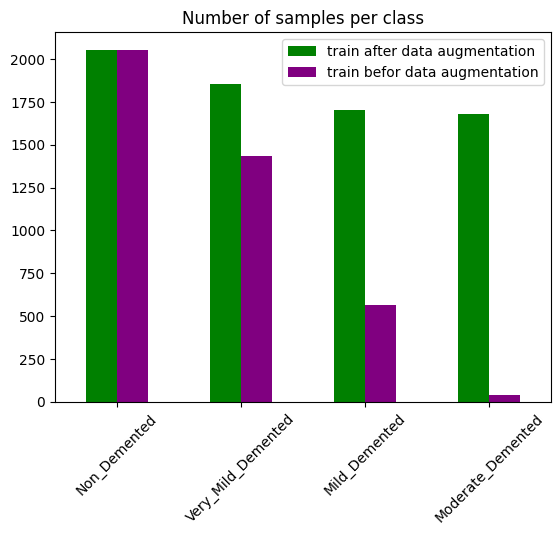

In [19]:
##### plot class distribution before and after the augmentation #####
train_labels_names=['Mild_Demented' if el==0 else 'Moderate_Demented' if el==1 else 'Non_Demented'  if el==2 else 'Very_Mild_Demented'   for el in augmented_labels]
vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels_names).value_counts(normalize=vis_ratio), pd.Series(train_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', title=vis_title, rot=45, color = ['green', 'purple']) # added color to avoid confusion with train/val color setting
plt.legend(['train after data augmentation', 'train befor data augmentation'])
plt.savefig('Data augmentation results.png')

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

# Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

def dense_block(units, dropout_rate, L2): # add regularization at the dense layer (dense layer has are more or less fulliconnected, is important to reguraraze weight in order to avoid overfitting)
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2)),
        tf.keras.layers.BatchNormalization(), #change the layer: is not practice use a batch normalization after a relu activation
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

def build_model_original():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7, 0),
        dense_block(128, 0.5, 0),
        dense_block(64, 0.2, 0),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

def build_model_tunable(L2,drop_out):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(drop_out),

        conv_block(256),
        tf.keras.layers.Dropout(drop_out),

        tf.keras.layers.Flatten(),
        dense_block(512, drop_out*3, L2),
        dense_block(128, drop_out*2, L2),
        dense_block(64, drop_out, L2),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

In [ ]:
#tf.keras.utils.plot_model(model, to_file="cnn.png", show_shapes=True) #plot the network

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

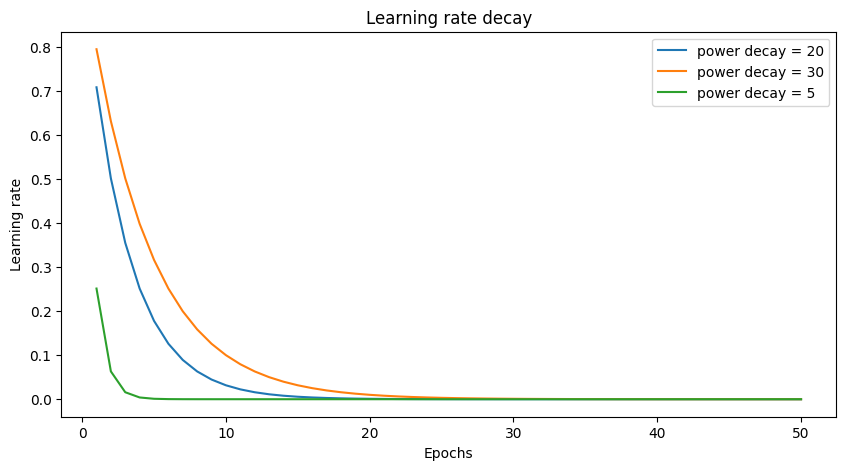

In [ ]:
def exponential_decay(s):
    def exponential_decay_fn(epoch):
        return 0.001 **(epoch / s)
    return exponential_decay_fn

epochs=np.linspace(1,50,50)
lr_epochs=0.001**(epochs / 20)
lr_epochs2=0.001**(epochs/30)
lr_epochs3=0.001**(epochs / 5)

plt.figure(figsize=(10,5))
plt.plot(epochs, lr_epochs,label="power decay = 20")
plt.plot(epochs, lr_epochs2,label="power decay = 30")
plt.plot(epochs, lr_epochs3,label="power decay = 5")

plt.title("Learning rate decay")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.legend()

plt.savefig('Learning_Rate_Decay.png')

Let's fit our model!

In [ ]:
# ORIGINAL MODEL WITH ORIGINAL DATA
model_name = 'Original_model.h5'
EPOCHS = 100

with strategy.scope():
    model = build_model_original()

    METRICS = [tf.keras.metrics.AUC(name='auc')]

    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

exponential_decay_fn = exponential_decay(20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history_original = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    verbose = 1, #progression bar
    epochs=EPOCHS
)

Epoch 1/100
256/256 [==============================] - ETA: 0s - loss: 19.4999 - auc: 0.6184

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - 79s 287ms/step - loss: 19.4999 - auc: 0.6184 - val_loss: 2926531928129536.0000 - val_auc: 0.4682 - lr: 1.0000
Epoch 2/100
256/256 [==============================] - 74s 290ms/step - loss: 4.9106 - auc: 0.6729 - val_loss: 2.0376 - val_auc: 0.7217 - lr: 0.7079
Epoch 3/100
256/256 [==============================] - 72s 281ms/step - loss: 1.5422 - auc: 0.7428 - val_loss: 1.3765 - val_auc: 0.7445 - lr: 0.5012
Epoch 4/100
256/256 [==============================] - 72s 283ms/step - loss: 1.2469 - auc: 0.7508 - val_loss: 1.1468 - val_auc: 0.7937 - lr: 0.3548
Epoch 5/100
256/256 [==============================] - 73s 285ms/step - loss: 1.1095 - auc: 0.7693 - val_loss: 1.0635 - val_auc: 0.7917 - lr: 0.2512
Epoch 6/100
256/256 [==============================] - 72s 281ms/step - loss: 1.0631 - auc: 0.7788 - val_loss: 1.0613 - val_auc: 0.8085 - lr: 0.1778
Epoch 7/100
256/256 [==============================] - 70s 275ms/step - loss: 1.0468 - auc: 0.7826 - v

In [ ]:
# ORIGINAL MODEL WITH AUGMENTED DATA
model_name = 'Original_model_augmented_data.h5'
EPOCHS = 100

with strategy.scope():
    model = build_model_original()

    METRICS = [tf.keras.metrics.AUC(name='auc')]

    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

exponential_decay_fn = exponential_decay(20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history_original_AUG = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
    train_ds_aug,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    verbose = 1, #progression bar
    epochs=EPOCHS
)

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 13.1584 - auc: 0.5185

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 137s 2s/step - loss: 13.1584 - auc: 0.5185 - val_loss: 1995.0793 - val_auc: 0.3598 - lr: 1.0000
Epoch 2/100
72/72 [==============================] - 137s 2s/step - loss: 2.2706 - auc: 0.5891 - val_loss: 17.3946 - val_auc: 0.6631 - lr: 0.7079
Epoch 3/100
72/72 [==============================] - 127s 2s/step - loss: 1.3881 - auc: 0.6336 - val_loss: 1.3189 - val_auc: 0.7561 - lr: 0.5012
Epoch 4/100
72/72 [==============================] - 140s 2s/step - loss: 1.3555 - auc: 0.6456 - val_loss: 2.2760 - val_auc: 0.2884 - lr: 0.3548
Epoch 5/100
72/72 [==============================] - 127s 2s/step - loss: 1.3243 - auc: 0.6427 - val_loss: 2.4978 - val_auc: 0.7776 - lr: 0.2512
Epoch 6/100
72/72 [==============================] - 131s 2s/step - loss: 1.2781 - auc: 0.6652 - val_loss: 1.1176 - val_auc: 0.7637 - lr: 0.1778
Epoch 7/100
72/72 [==============================] - 135s 2s/step - loss: 1.2537 - auc: 0.6790 - val_loss: 1.5282 - val_auc: 0.4797 - lr:

In [ ]:
#Hyperparameter tuning with augmented data
'''
drop_out = [0.1, 0.2, 0.3]
s = [5, 20, 30]
L2 = [1e-4, 1e-3, 1e-2]
'''
drop_out = [0.1]
s = [20]
L2 = [1e-3]

EPOCHS = 40

hparam = {
    'drop_out' : drop_out,
    's' : s,
    'L2' : L2
}

hparam_grid = ParameterGrid(hparam)

history = dict()

for p in hparam_grid:
    drop_out = p['drop_out']
    s = p['s']
    L2 = p['L2']

    model_name = 's_'+str(s)+'_L2_'+str(L2)+'_dropOut_'+str(drop_out)+'.h5'

    with strategy.scope():
        model = build_model_tunable(L2,drop_out)

        METRICS = [tf.keras.metrics.AUC(name='auc')]

        model.compile(
            optimizer='adam',
            loss=tf.losses.CategoricalCrossentropy(),
            metrics=METRICS
        )

    exponential_decay_fn = exponential_decay(s)

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

    history[model_name] = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
        train_ds_aug,
        batch_size = BATCH_SIZE,
        validation_data=val_ds,
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
        verbose = 1, #progression bar
        epochs=EPOCHS
    )


Epoch 1/40


72/72 [==============================] - 119s 2s/step - loss: 932.1738 - auc: 0.5509 - val_loss: 44215.7539 - val_auc: 0.3399 - lr: 1.0000
Epoch 2/40
72/72 [==============================] - 104s 1s/step - loss: 933.6704 - auc: 0.5557 - val_loss: 4587.6299 - val_auc: 0.5666 - lr: 0.7079
Epoch 3/40
72/72 [==============================] - 102s 1s/step - loss: 387.6885 - auc: 0.5089 - val_loss: 150.6632 - val_auc: 0.4079 - lr: 0.5012
Epoch 4/40
72/72 [==============================] - 102s 1s/step - loss: 119.6970 - auc: 0.5477 - val_loss: 98.4021 - val_auc: 0.3955 - lr: 0.3548
Epoch 5/40
72/72 [==============================] - 104s 1s/step - loss: 94.1250 - auc: 0.5775 - val_loss: 75.5811 - val_auc: 0.7444 - lr: 0.2512
Epoch 6/40
72/72 [==============================] - 102s 1s/step - loss: 63.3415 - auc: 0.6012 - val_loss: 57.0294 - val_auc: 0.3085 - lr: 0.1778
Epoch 7/40
72/72 [==============================] - 102s 1s/step - loss: 53.0452 - auc: 0.6089 - val_loss: 49.1107 - val_auc:

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

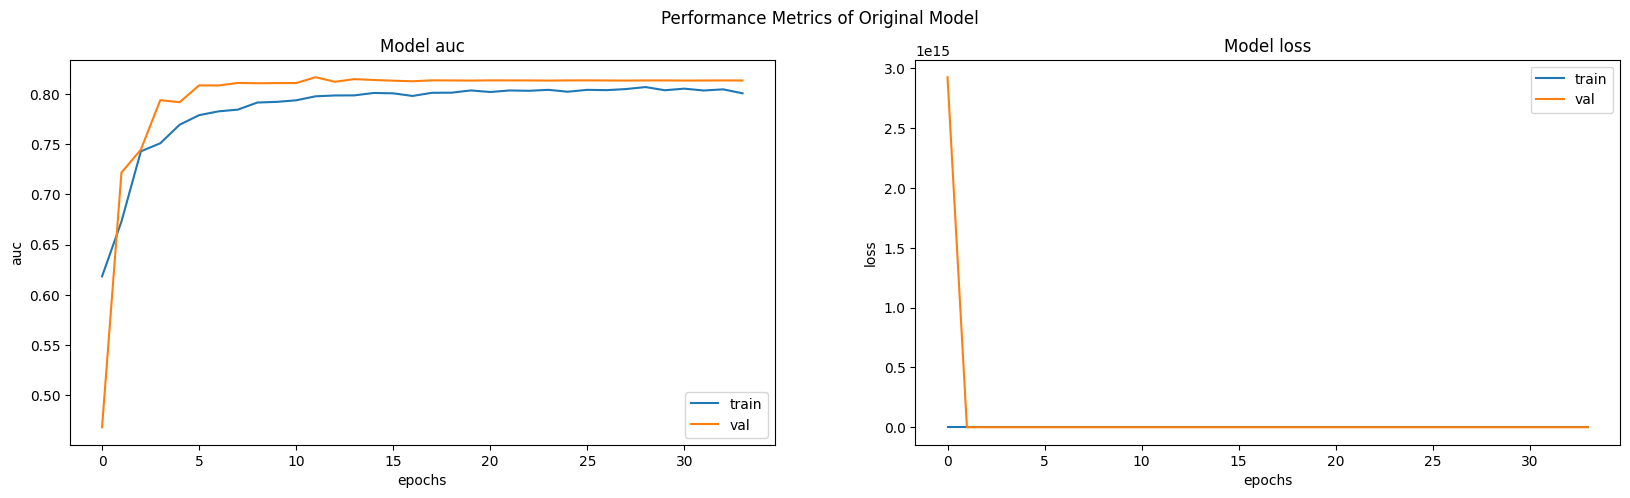

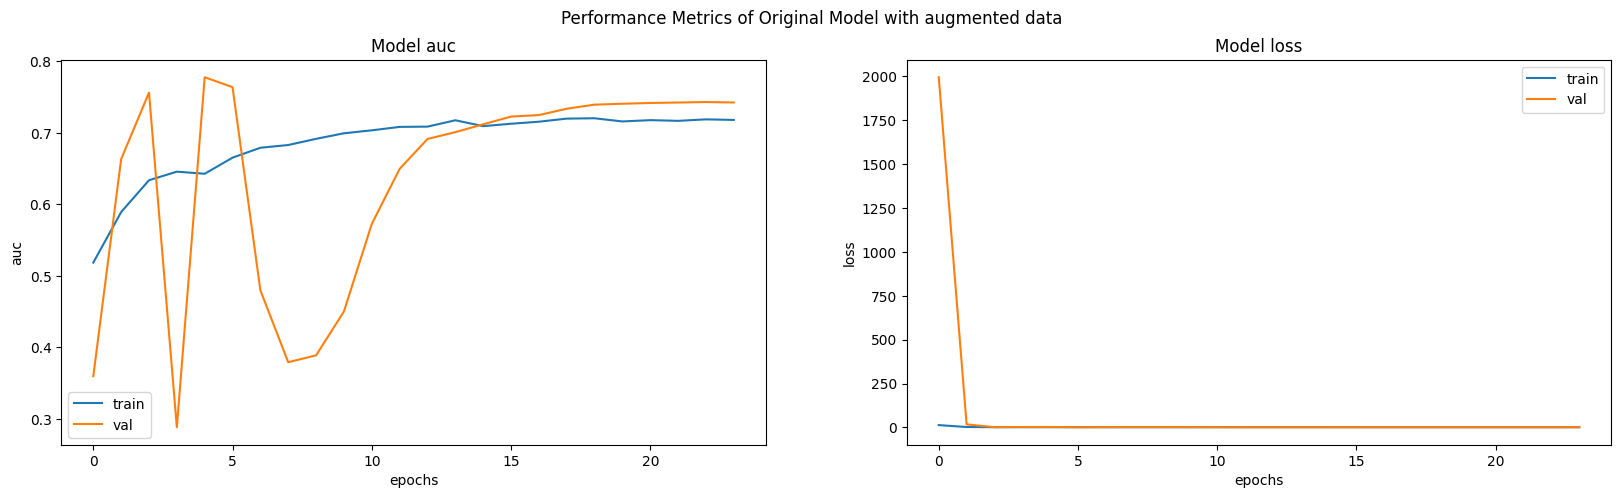

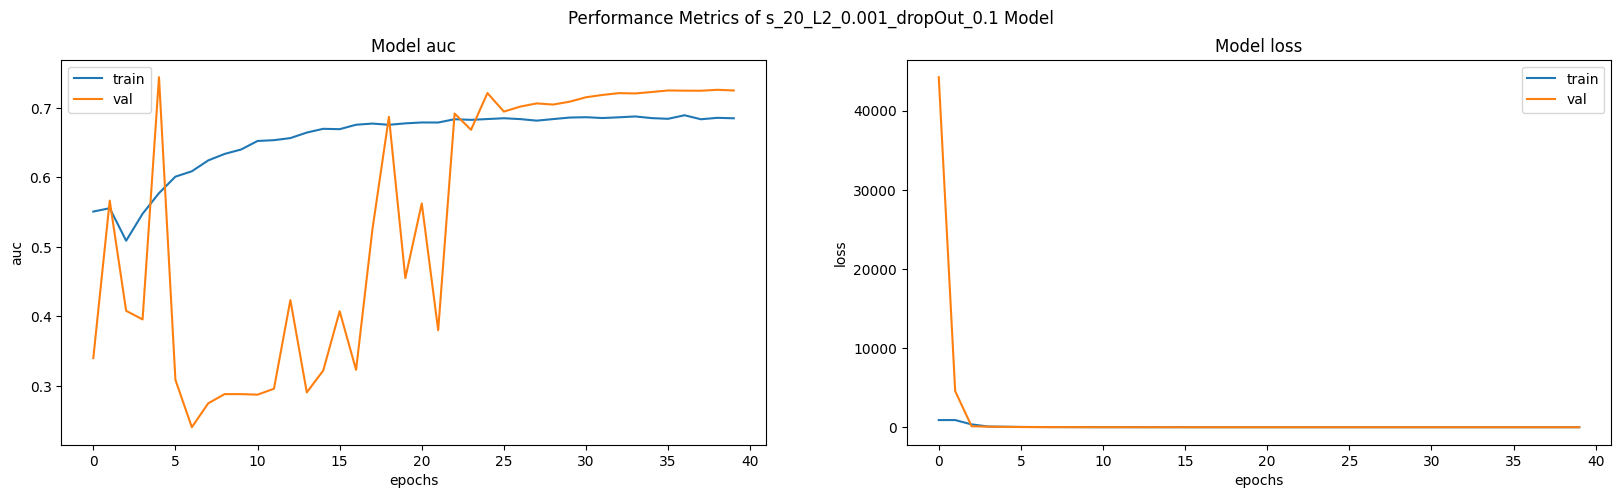

In [ ]:
# Original model
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_original.history[met])
    ax[i].plot(history_original.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of Original Model')

plt.savefig('Original_model.png')

# Original model AUGMENTED DATA
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_original_AUG.history[met])
    ax[i].plot(history_original_AUG.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of Original Model with augmented data')

plt.savefig('Original_model_AUG.png')


#tunable models with augmanted dataset
for k in history.keys():
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax = ax.ravel()
    for i, met in enumerate(['auc', 'loss']):
        ax[i].plot(history[k].history[met])
        ax[i].plot(history[k].history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

    plt.suptitle('Performance Metrics of '+k[:-3]+' Model')

    plt.savefig(k[:-3]+'.png')

# Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1281 files belonging to 4 classes.


In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	#This function plot confusion matrix method from sklearn package.


	plt.figure(figsize= (12, 12))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

	plt.savefig(title+'.png')


13/13 [==============================] - 4s 309ms/step
Test Loss:  0.9899918437004089
Test Accuracy:  0.8070577383041382
Confusion Matrix, Without Normalization
[[  0   0 118  62]
 [  0   0  11   2]
 [  0   0 538 102]
 [  0   0 341 107]]


C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00       180
 Moderate_Demented       0.00      0.00      0.00        13
      Non_Demented       0.53      0.84      0.65       640
Very_Mild_Demented       0.39      0.24      0.30       448

          accuracy                           0.50      1281
         macro avg       0.23      0.27      0.24      1281
      weighted avg       0.40      0.50      0.43      1281

13/13 [==============================] - 5s 346ms/step
Test Loss:  1.1302696466445923
Test Accuracy:  0.7610586881637573
Confusion Matrix, Without Normalization
[[  0  68 112   0]
 [  0   4   9   0]
 [  0  86 554   0]
 [  0 102 346   0]]
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00       180
 Moderate_Demented       0.02      0.31      0.03        13
      Non_Demented       0.54      0.87      0.67       640
Very_Mild_Demented       0.00      0.0

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

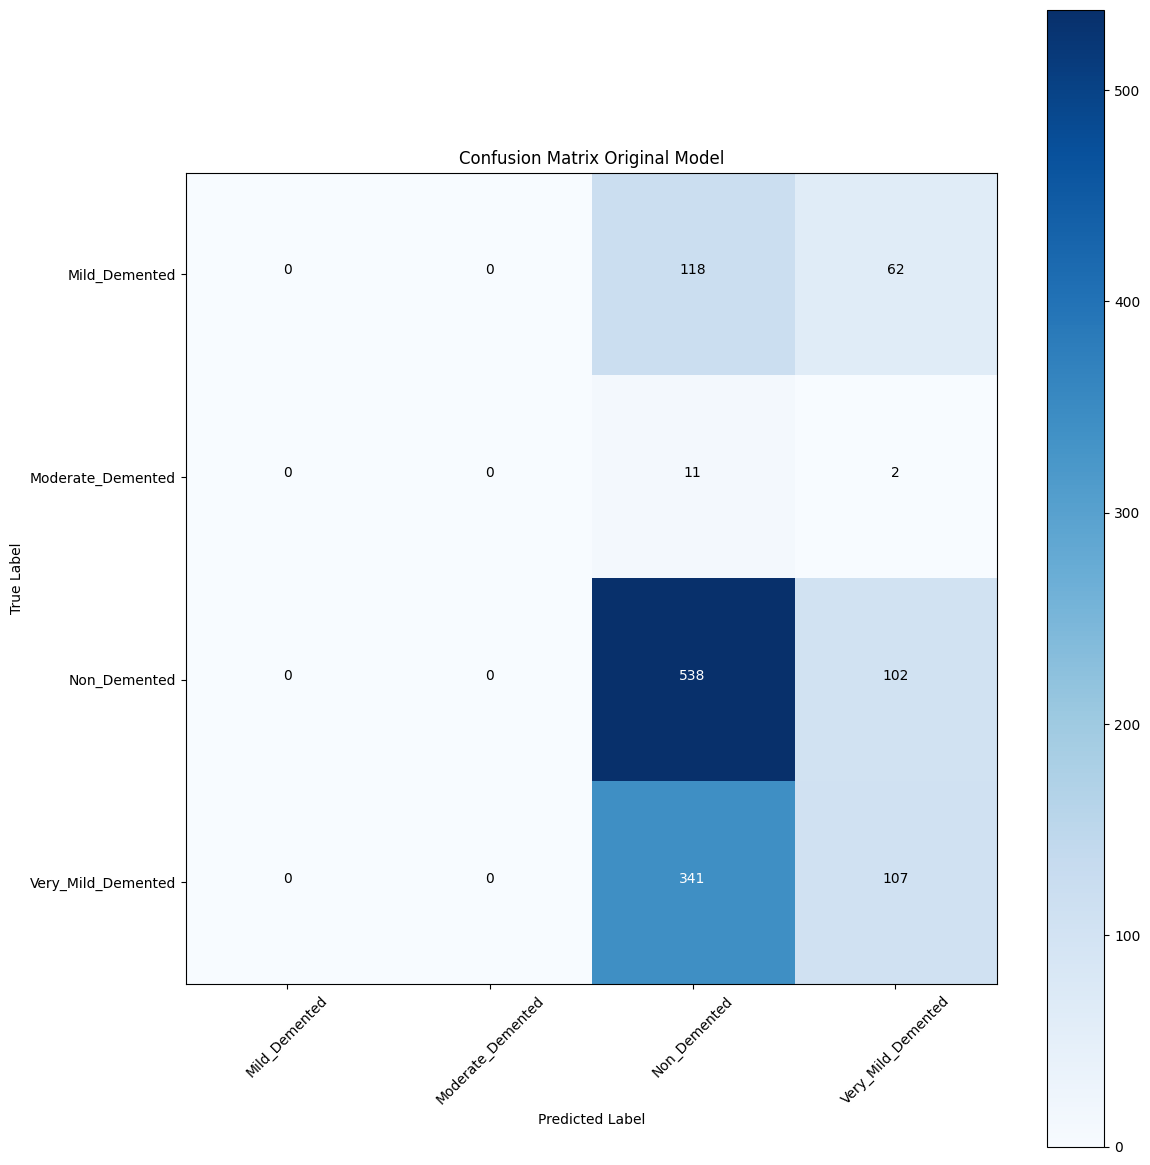

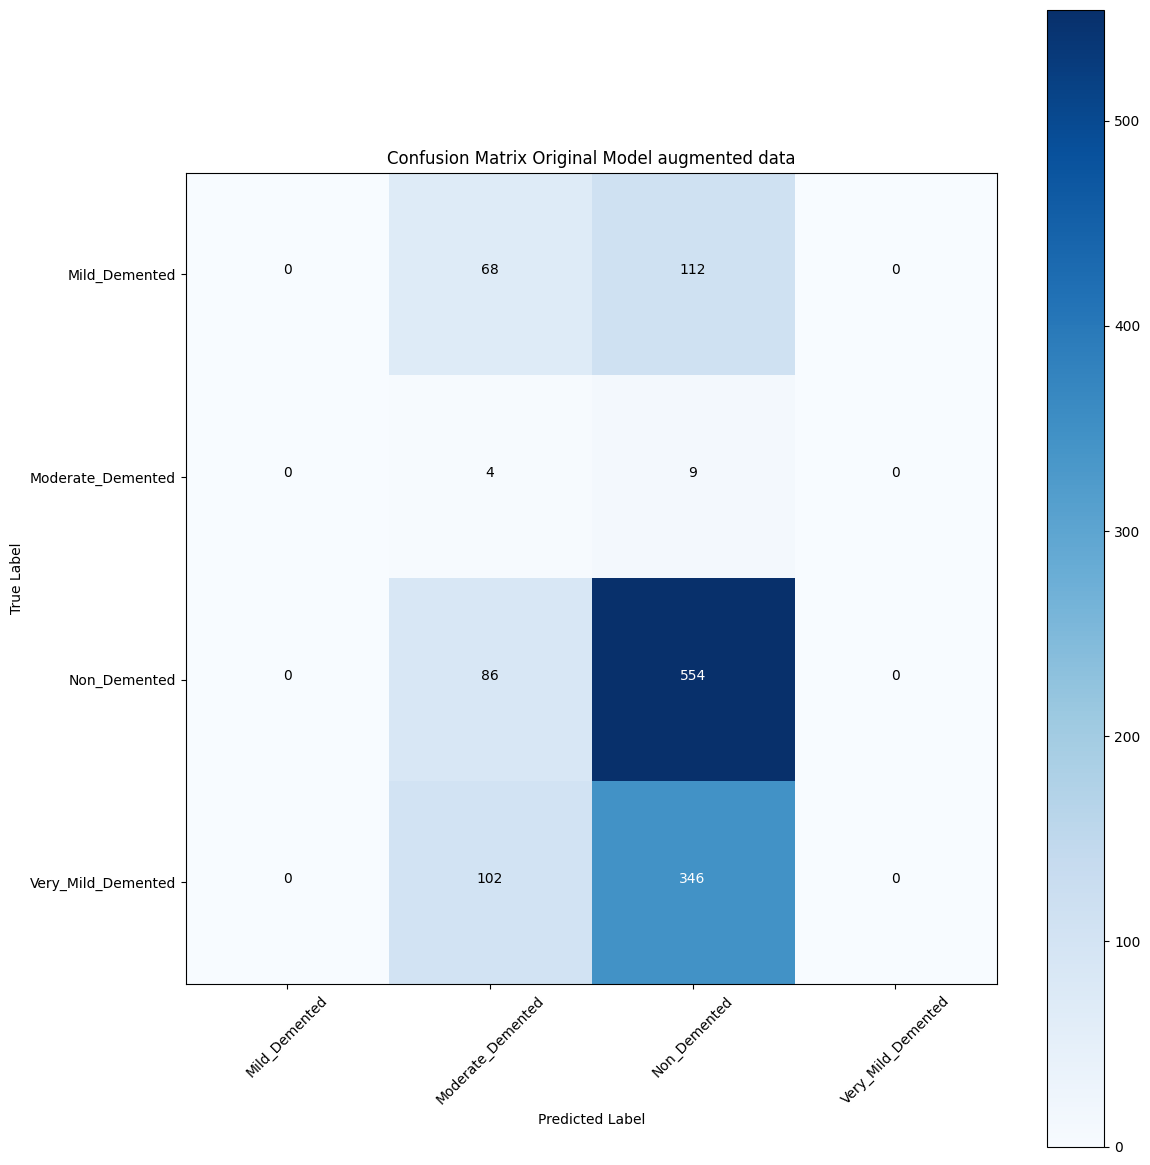

In [ ]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools

y_true=labels_fromPrefetch(test_ds)

model = load_model('Original_model.h5')
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix Original Model')
print(classification_report(y_true, y_pred, target_names= classes))

model = load_model('Original_model_augmented_data.h5')
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix Original Model augmented data')
print(classification_report(y_true, y_pred, target_names= classes))


13/13 [==============================] - 5s 328ms/step
Test Loss:  29.860427856445312
Test AUC:  0.7118409276008606
Confusion Matrix, Without Normalization
[[ 79  10  25  66]
 [  3   2   5   3]
 [115  31 385 109]
 [119  27 162 140]]
                    precision    recall  f1-score   support

     Mild_Demented       0.25      0.44      0.32       180
 Moderate_Demented       0.03      0.15      0.05        13
      Non_Demented       0.67      0.60      0.63       640
Very_Mild_Demented       0.44      0.31      0.37       448

          accuracy                           0.47      1281
         macro avg       0.35      0.38      0.34      1281
      weighted avg       0.52      0.47      0.49      1281



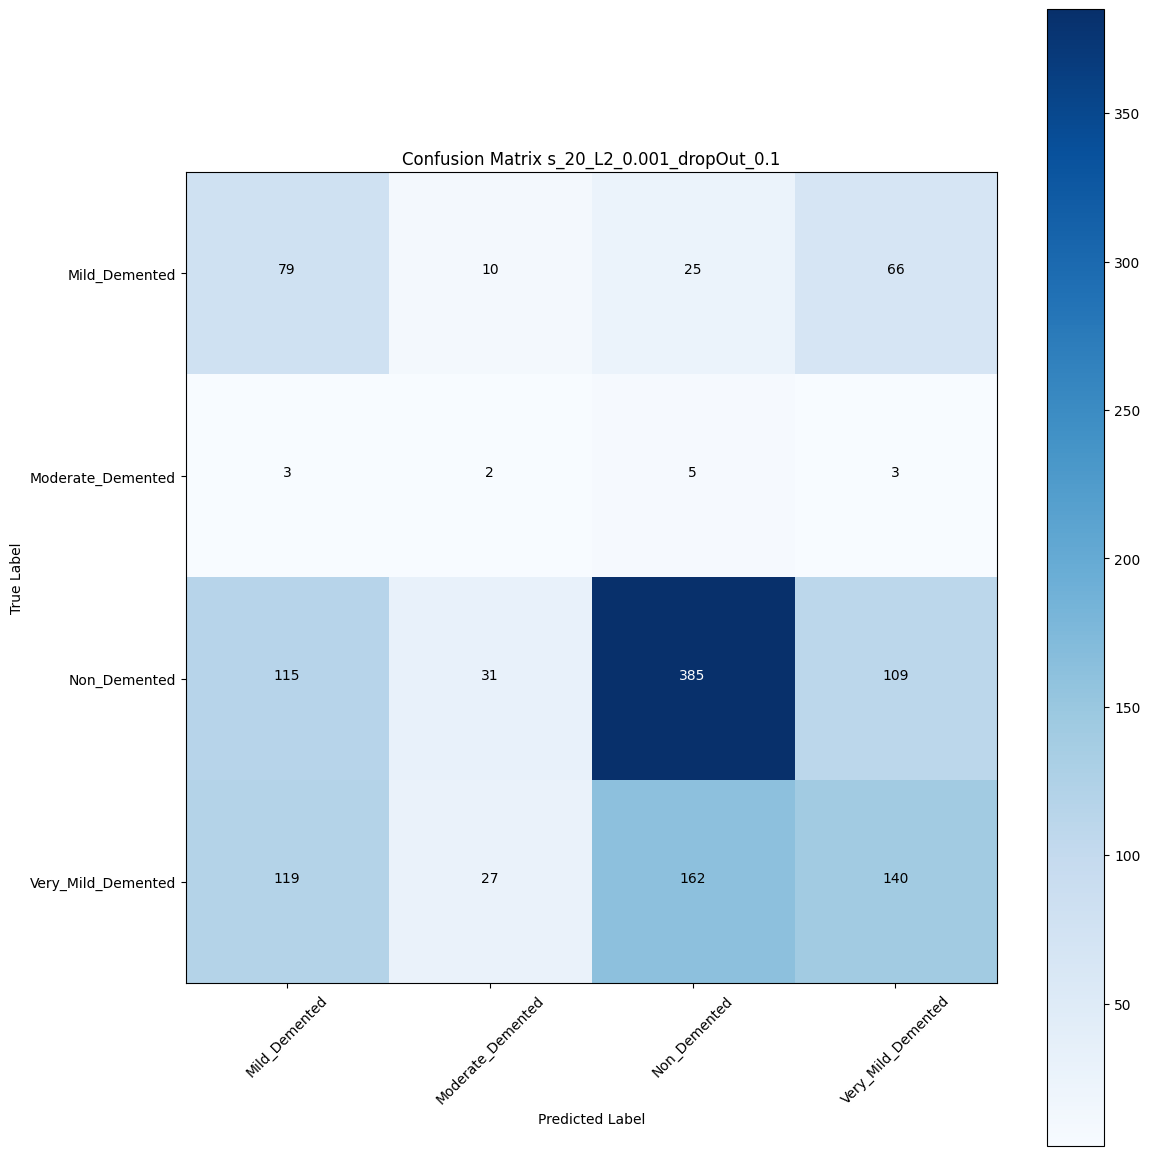

In [ ]:
for k in history.keys():
    model = load_model(k)
    test_score = model.evaluate(test_ds)
    test_pred = model.predict(test_ds)
    y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
    print("Test Loss: ", test_score[0])
    print("Test AUC: ", test_score[1])

    cm= confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix '+k[:-3])
    print(classification_report(y_true, y_pred, target_names= classes))
